In [2]:
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

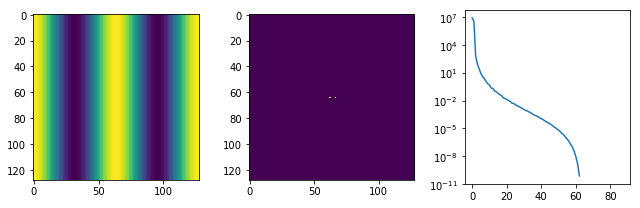

In [39]:
X,Y = np.meshgrid(np.linspace(0,32,128),np.linspace(0,32,128))
image = np.exp(1j*((2.0*np.pi)/16)*X).real
def plotPSD(image):
    fig,ax = plt.subplots(1,3,figsize=(3*3,3))
    
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)
    
    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift(F1)
    
    # Calculate a 2D power spectrum
    psd2D = np.fabs(F2.real)**2
    
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    
    # Now plot up both
    ax[0].imshow(image)
    ax[1].imshow(psd2D)
    ax[2].semilogy(psd1D )
    plt.tight_layout()
    #plt.xlabel('Spatial Frequency')
    #plt.ylabel('Power Spectrum')
plotPSD(image)

In [33]:
print np.linspace(0,32,128)[np.argmax(psd1D)]
print (2.0*np.pi)/16

0.251968503937
0.392699081699
